In [2]:
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from scipy import stats
from nltk import ngrams
from nltk.corpus import wordnet as wn
from krovetzstemmer import Stemmer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import cluster
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import numpy as np
from collections import Counter
import operator
from itertools import chain
from tpot import TPOTClassifier
import xgboost
import scipy as sp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split as tts
from textblob import TextBlob, Word
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder, Imputer
from sklearn.metrics import f1_score as f1, silhouette_score as sil
from sklearn.decomposition import PCA
from sklearn.externals import joblib
import string
from sklearn.cluster import KMeans

C:\Users\visha\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (16, 8)

In [4]:
stop = stopwords.words('english')
ss = StandardScaler()
mabs = MaxAbsScaler()
pca = PCA()
p_stemmer = PorterStemmer()
sn_stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
imp = Imputer('mean')
k_stemmer = Stemmer()
le = LabelEncoder()
mas = MaxAbsScaler()
#k_stemmer.stem('lovingly')
tpot = TPOTClassifier(generations = 5, population_size = 20, verbosity = 3)

In [5]:
df = pd.read_csv('Desktop/Datasets/Locale.ai/data.csv', header = 0, index_col = None)

In [6]:
df.columns

Index(['id', 'user_id', 'vehicle_model_id', 'package_id', 'travel_type_id',
       'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'from_date',
       'to_date', 'online_booking', 'mobile_site_booking', 'booking_created',
       'from_lat', 'from_long', 'to_lat', 'to_long', 'Car_Cancellation'],
      dtype='object')

In [7]:
df['from_lat'] = df['from_lat'].fillna(np.mean(df['from_lat']))
df['from_long'] = df['from_long'].fillna(np.mean(df['from_long']))
df['to_lat'] = df['to_lat'].fillna(np.mean(df['to_lat']))
df['to_long'] = df['to_long'].fillna(np.mean(df['to_long']))

In [8]:
# remove obvious outliers
allLat  = np.array(list(df['from_lat'])  + list(df['to_lat']))
allLong = np.array(list(df['from_long']) + list(df['to_long']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]

df = df[(df['from_lat']   >= latLimits[0] ) & (df['from_lat']   <= latLimits[1]) ]
df = df[(df['to_lat']  >= latLimits[0] ) & (df['to_lat']  <= latLimits[1]) ]
df = df[(df['from_long']  >= longLimits[0]) & (df['from_long']  <= longLimits[1])]
df = df[(df['to_long'] >= longLimits[0]) & (df['to_long'] <= longLimits[1])]
df = df.reset_index(drop = True)

allLat  = np.array(list(df['from_lat'])  + list(df['to_lat']))
allLong = np.array(list(df['from_long']) + list(df['to_long']))

In [9]:
longLimits

[77.480214, 77.74935]

In [10]:
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0


In [11]:
# convert fields to sensible units
medianLat  = np.percentile(allLat, 50)
medianLong = np.percentile(allLong, 50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

df['src lat [km]']   = latMultiplier  * (df['from_lat']   - medianLat)
df['src long [km]']  = longMultiplier * (df['from_long']  - medianLong)
df['dst lat [km]']   = latMultiplier  * (df['to_lat']  - medianLat)
df['dst long [km]']  = longMultiplier * (df['to_long'] - medianLong)

In [12]:
allLat  = np.array(list(df['src lat [km]'])  + list(df['dst lat [km]']))
allLong = np.array(list(df['src long [km]']) + list(df['dst long [km]']))

In [13]:
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,src lat [km],src long [km],dst lat [km],dst long [km]
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,...,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,-6.282901,3.438078,-5.930016,-0.525611
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,...,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,-1.522858,11.797189,-5.889941,-1.513822
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,...,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,-4.827726,-1.483991,7.495844,-4.645939
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,...,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.046408,-9.467235,-1.019691,-0.157880
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,...,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,-15.021187,4.049337,-2.922150,-4.325503


In [14]:
allLat

array([-6.2829008 , -1.5228576 , -4.82772576, ...,  5.12723045,
       -4.7155152 , 24.3757404 ])

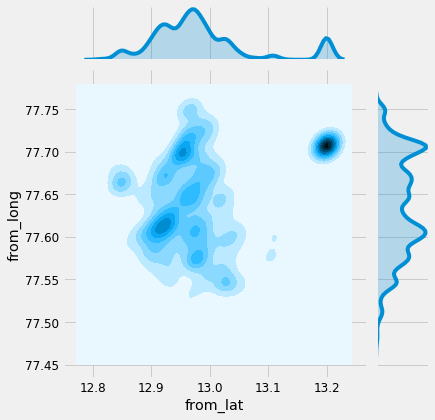

In [70]:
sns.jointplot(x = 'from_lat', y = 'from_long', data = df, kind = 'kde')
plt.show()

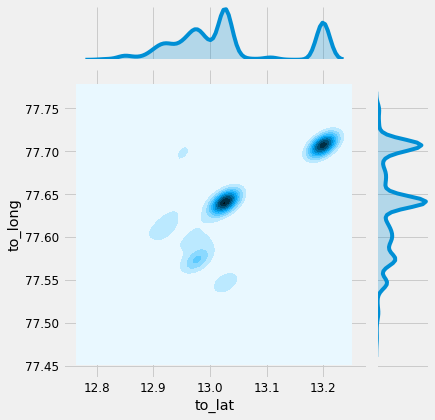

In [71]:
sns.jointplot(x = 'to_lat', y = 'to_long', data = df, kind = 'kde')
plt.show()

In [19]:
imageSize = (700, 700)
longRange = [-30, 30]
latRange = [-30, 30]

allLatInds = imageSize[0] - (imageSize[0] * (allLat  - latRange[0]) / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds = (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds, allLongInds):
    locationDensityImage[latInd, longInd] += 1

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 12))
ax.imshow(np.log(locationDensityImage + 1), cmap = 'hot')

plt.savefig('surgemap.png', dpi = 1500, quality = 95)

#plt.show()

In [20]:
tripAttributes = np.array(df.loc[:,['src lat [km]', 'src long [km]', 'dst lat [km]','dst long [km]']])
meanTripAttr = tripAttributes.mean(axis = 0)
stdTripAttr  = tripAttributes.std(axis = 0)
tripAttributes = stats.zscore(tripAttributes, axis = 0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters = numClusters, batch_size = 12000, n_init = 100, random_state = 1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins = numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

In [22]:
len(np.unique(clusterInds))

80

In [23]:
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])/(latRange[1]  - latRange[0])).astype(int)
    longInds = (imageSize[1]*(longCoord - longRange[0])/(longRange[1] - longRange[0])).astype(int)
    return latInds, longInds

In [24]:
templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize = (12, 12))
plt.imshow(np.log(locationDensityImage + 1),cmap = 'hot')
plt.scatter(srcImCoords[1], srcImCoords[0], c = 'm', s = 50, alpha = 0.8)
plt.scatter(dstImCoords[1], dstImCoords[0], c = 'g', s = 50, alpha = 0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i], srcImCoords[0][i], dstImCoords[1][i] - srcImCoords[1][i], dstImCoords[0][i] - srcImCoords[0][i], 
              edgecolor = 'c', facecolor = 'c', width = 0.8, alpha = 0.4, head_width = 10.0, head_length = 10.0, length_includes_head = True)

plt.savefig('cluster.png', dpi = 1500, quality = 95)

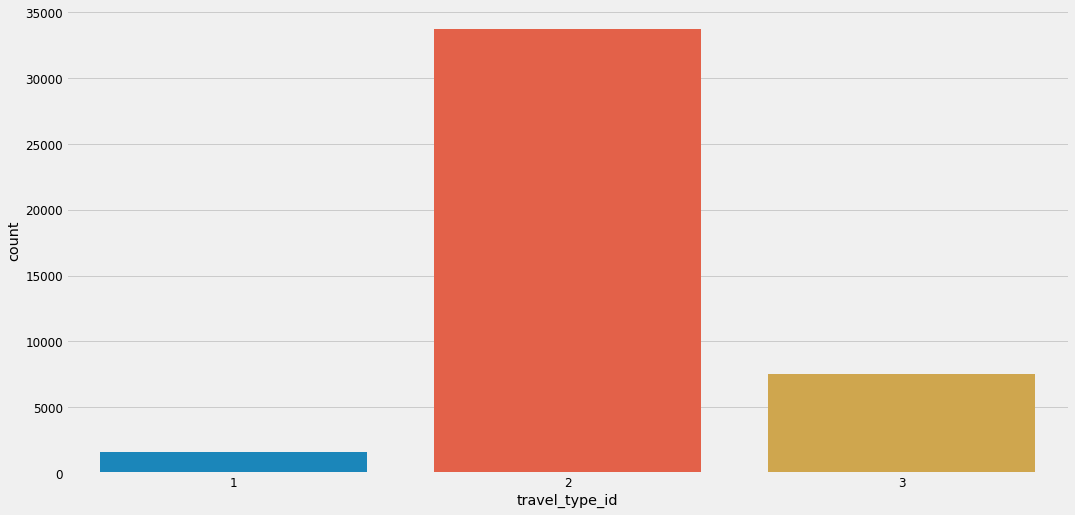

In [30]:
sns.countplot(df['travel_type_id'])
plt.show()

In [26]:
travel_type = df.groupby('travel_type_id').median().reset_index()

In [27]:
travel_type.head()

,travel_type_id,id,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,src lat [km],src long [km],dst lat [km],dst long [km]
0,1,159009,33492,24,NaN,571.0,1080.0,15.0,49.0,0,0,12.97440,77.649047,13.026648,77.640595,0,-0.689071,0.916785,5.127230,0.00000
1,2,159442,31968,12,NaN,590.0,541.0,15.0,NaN,0,0,12.97003,77.635750,12.983900,77.645030,0,-1.175539,-0.525611,0.368469,0.48104
2,3,159147,30459,12,2.0,708.0,NaN,15.0,NaN,0,0,12.96298,77.633540,13.026648,77.640595,0,-1.960345,-0.765342,5.127230,0.00000


In [28]:
travel_type['from_lat'].head()

0    12.97440
1    12.97003
2    12.96298
Name: from_lat, dtype: float64

In [29]:
travel_type['from_long'].head()

0    77.649047
1    77.635750
2    77.633540
Name: from_long, dtype: float64

In [31]:
#%% create some new usefull fields
pickupTime = pd.to_datetime(df['from_date'])

df['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)/ 60.0

df['dayOfWeek'] = pickupTime.dt.weekday
df['hourOfWeek'] = df['dayOfWeek']*24.0 + df['src hourOfDay']

df['monthOfYear'] = pickupTime.dt.month
df['dayOfYear'] = pickupTime.dt.dayofyear
df['weekOfYear'] = pickupTime.dt.weekofyear
df['hourOfYear'] = df['dayOfYear']*24.0 + df['src hourOfDay']

In [32]:
df.tail()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
42826,185937,14364,12,NaN,2,1147.0,452.0,15.0,NaN,11/24/2013 18:00,...,0.922535,-3.095809,-5.392901,18.0,6,162.0,11,328,47,7890.0
42827,185938,48727,12,NaN,2,393.0,466.0,15.0,NaN,11/26/2013 1:00,...,7.190240,4.101697,0.432226,1.0,1,25.0,11,330,48,7921.0
42828,185939,48729,12,1.0,3,974.0,NaN,15.0,NaN,11/24/2013 18:30,...,-8.846756,5.127230,0.000000,18.5,6,162.5,11,328,47,7890.5
42829,185940,30724,87,NaN,2,1263.0,542.0,15.0,NaN,11/24/2013 16:00,...,-4.993711,-4.715515,-1.920604,16.0,6,160.0,11,328,47,7888.0
42830,185941,48730,12,NaN,2,689.0,393.0,15.0,NaN,11/25/2013 5:00,...,0.940975,24.375740,7.190240,5.0,0,5.0,11,329,48,7901.0


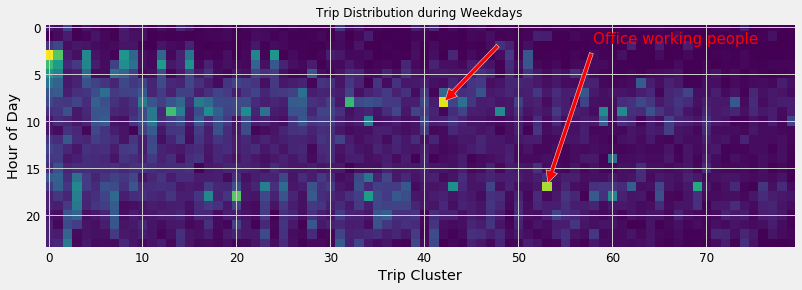

In [45]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(df['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay), numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (df['src hourOfDay'].astype(int) == hour) & (df['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins = numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (12, 6))
ax.set_title('Trip Distribution during Weekdays', fontsize = 12)
ax.imshow(clusterDistributionHourOfDay_weekday)
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Office working people', color = 'r', fontsize = 15, xy = (53, 17), xytext = (58, 1.75),
            arrowprops = dict(facecolor='red', shrink=0.03))
ax.annotate('', color = 'r', fontsize = 15, xy = (42, 8), xytext = (48, 1.75),
            arrowprops = dict(facecolor='red', shrink=0.03))

plt.savefig('Trip Distribution during Weekdays.png', dpi = 1500, quality = 95)
plt.show()

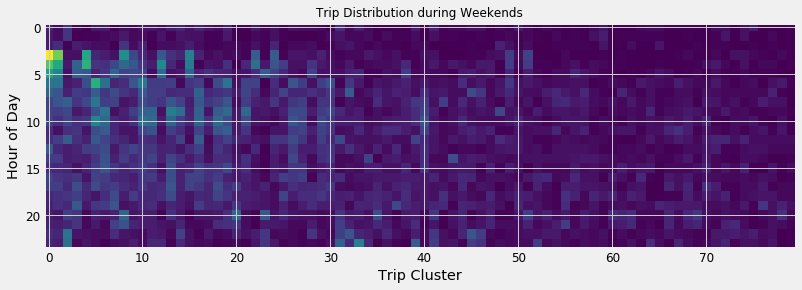

In [41]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(df['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay), numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (df['src hourOfDay'].astype(int) == hour) & (df['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins = numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize =( 12,6))
ax.set_title('Trip Distribution during Weekends', fontsize = 12)
ax.imshow(clusterDistributionHourOfDay_weekend)
ax.set_xlabel('Trip Cluster')
ax.set_ylabel('Hour of Day')

plt.savefig('Trip Distribution during Weekends.png', dpi = 1500, quality = 95)

plt.show()

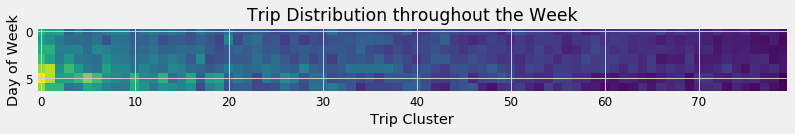

In [47]:
# calculate the trip distribution for day of week
daysOfWeek = np.sort(df['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = df['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins = numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize = (12 ,5))
plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek)
plt.xlabel('Trip Cluster')
plt.ylabel('Day of Week')

plt.savefig('Trip Distribution throughout the Week.png', dpi = 1500, quality = 95)

plt.show()

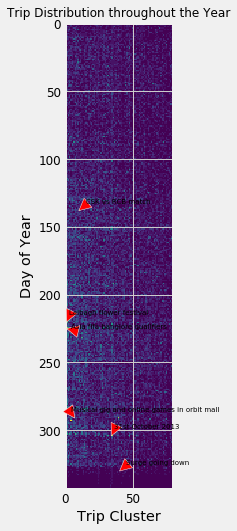

In [106]:
# calculate the trip distribution for day of year
daysOfYear = df['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear), numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = df['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins = numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (16, 8))
ax.set_title('Trip Distribution throughout the Year', fontsize = 12)
ax.imshow(clusterDistributionDayOfYear)
ax.set_xlabel('Trip Cluster')
ax.set_ylabel('Day of Year')
ax.annotate('CSK vs RCB match', color = 'k', fontsize = 7, xy = (10, 138), xytext = (15, 133),
            arrowprops = dict(facecolor = 'red'))
ax.annotate('Lalbagh flower festival', color = 'k', fontsize = 7, xy = (1, 220), xytext = (3, 215),
            arrowprops = dict(facecolor = 'red'))
ax.annotate('Asia fifa banglore qualifiers', color = 'k', fontsize = 7, xy = (1, 225), xytext = (4, 225),
            arrowprops = dict(facecolor = 'red'))
ax.annotate('Musical gig and online games in orbit mall', color = 'k', fontsize = 7, xy = (7, 291), xytext = (4, 286),
            arrowprops = dict(facecolor = 'red'))
ax.annotate('31st October 2013', color = 'k', fontsize = 7, xy = (34, 304), xytext = (36, 299),
            arrowprops = dict(facecolor = 'red'))
ax.annotate('Surge going down', color = 'k', fontsize = 7, xy = (40, 330), xytext = (45, 325),
            arrowprops = dict(facecolor = 'red'))

plt.savefig('Trip Distribution throughout the Year.png', dpi = 1500, quality = 95)

plt.show()

138 -> 18th May 2013 -> CSK vs RCB;
220 -> 8-9th Aug 2013 -> Lalbag Flower show;
225 -> 13-14th Aug 2013 -> Asia FIFA gaming banglore qualifiers
291 -> 18th - 20th October -> music gig and gaming 
310 -> 31st October

In [52]:
df.columns

Index(['id', 'user_id', 'vehicle_model_id', 'package_id', 'travel_type_id',
       'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'from_date',
       'to_date', 'online_booking', 'mobile_site_booking', 'booking_created',
       'from_lat', 'from_long', 'to_lat', 'to_long', 'Car_Cancellation',
       'src lat [km]', 'src long [km]', 'dst lat [km]', 'dst long [km]',
       'src hourOfDay', 'dayOfWeek', 'hourOfWeek', 'monthOfYear', 'dayOfYear',
       'weekOfYear', 'hourOfYear'],
      dtype='object')

In [55]:
_18_th_may = df[df['dayOfYear'] == 138]

In [56]:
_18_th_may.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
count,133.000000,133.000000,133.000000,25.0,133.000000,132.000000,94.000000,11.000000,14.000000,133.000000,...,133.000000,133.000000,133.000000,133.000000,133.0,133.000000,133.0,133.0,133.0,133.000000
mean,149700.593985,25898.721805,23.706767,1.4,2.082707,800.810606,614.042553,11.181818,67.428571,0.428571,...,-0.130798,5.927491,0.367097,12.000000,5.0,132.000000,5.0,138.0,20.0,3324.000000
std,322.056626,8553.149155,24.280801,0.5,0.537180,429.377308,368.104617,6.539391,46.767369,0.496743,...,6.029113,11.107142,5.793709,6.652139,0.0,6.652139,0.0,0.0,0.0,6.652139
min,148147.000000,694.000000,10.000000,1.0,1.000000,22.000000,87.000000,1.000000,29.000000,0.000000,...,-15.216103,-14.594943,-12.901131,0.000000,5.0,120.000000,5.0,138.0,20.0,3312.000000
25%,149702.000000,23336.000000,12.000000,1.0,2.000000,393.000000,393.000000,8.000000,32.000000,0.000000,...,-4.315740,-0.689071,-4.218112,7.000000,5.0,127.000000,5.0,138.0,20.0,3319.000000
50%,149763.000000,30420.000000,12.000000,1.0,2.000000,982.500000,441.500000,15.000000,55.000000,0.000000,...,0.540701,5.127230,0.000000,10.500000,5.0,130.500000,5.0,138.0,20.0,3322.500000
75%,149848.000000,31192.000000,12.000000,2.0,2.000000,1165.000000,844.750000,15.000000,63.250000,1.000000,...,4.703768,5.336681,7.190240,18.000000,5.0,138.000000,5.0,138.0,20.0,3330.000000
max,149967.000000,40444.000000,87.000000,2.0,3.000000,1391.000000,1389.000000,15.000000,160.000000,1.000000,...,11.797189,24.375740,11.797189,23.750000,5.0,143.750000,5.0,138.0,20.0,3335.750000


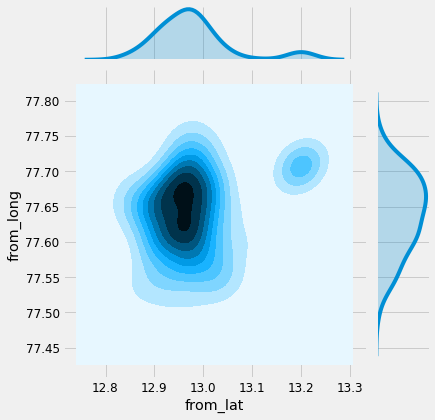

In [68]:
sns.jointplot(x = 'from_lat', y = 'from_long', data = _18_th_may, kind = 'kde')
plt.show()

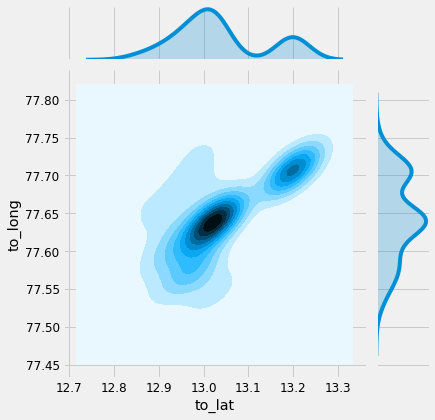

In [67]:
sns.jointplot(x = 'to_lat', y = 'to_long', data = _18_th_may, kind = 'kde')
plt.show()

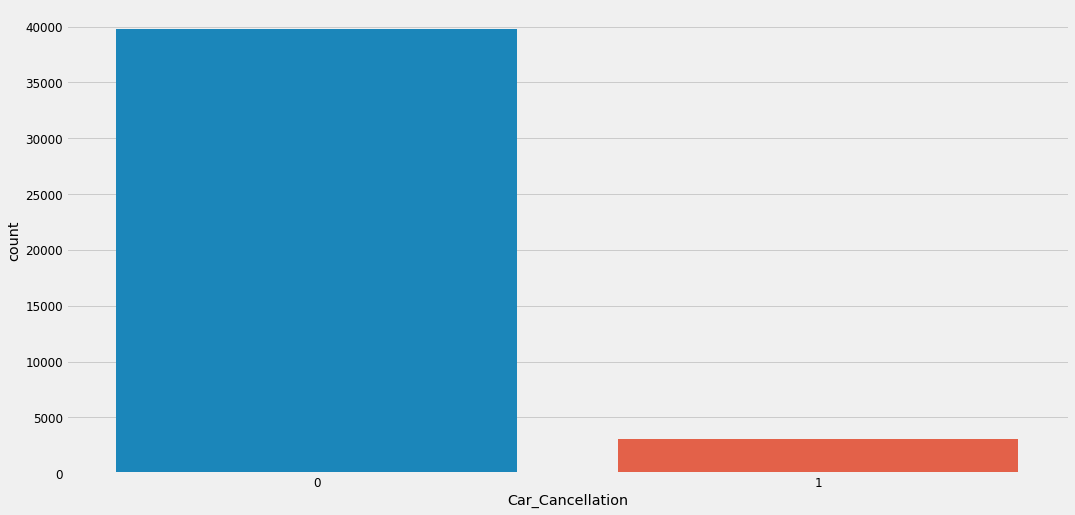

In [107]:
sns.countplot(x = 'Car_Cancellation', data = df)
plt.show()

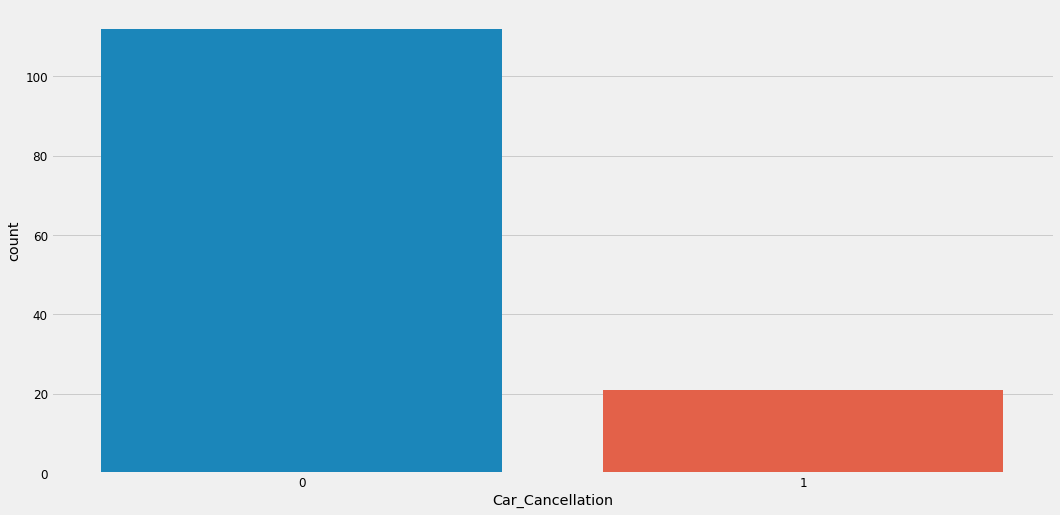

In [72]:
sns.countplot(x = 'Car_Cancellation', data = _18_th_may)
plt.show()

In [74]:
df[df['dayOfYear'] == 220]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
24012,162636,37552,12,NaN,2,499.0,176.0,15.0,NaN,8/8/2013 6:00,...,0.873721,-8.158643,5.914570,6.00,3,78.00,8,220,32,5286.00
24579,163340,33882,12,NaN,2,410.0,1026.0,NaN,NaN,8/8/2013 14:15,...,-10.789549,13.829284,-6.973386,14.25,3,86.25,8,220,32,5294.25
24613,163379,37906,12,NaN,2,393.0,1295.0,15.0,NaN,8/8/2013 6:00,...,7.190240,-5.735095,-1.397970,6.00,3,78.00,8,220,32,5286.00
24739,163543,37984,89,NaN,2,689.0,1399.0,15.0,NaN,8/8/2013 16:30,...,0.940975,-3.965775,4.673178,16.50,3,88.50,8,220,32,5296.50
24896,163740,38068,12,NaN,2,471.0,393.0,15.0,NaN,8/8/2013 5:00,...,-0.580934,24.375740,7.190240,5.00,3,77.00,8,220,32,5285.00
24990,163848,34972,12,NaN,2,1041.0,949.0,15.0,NaN,8/8/2013 9:30,...,2.625598,0.240451,-2.687525,9.50,3,81.50,8,220,32,5289.50
25040,163911,40512,12,NaN,2,571.0,625.0,15.0,NaN,8/8/2013 17:30,...,6.055588,-2.925490,1.595082,17.50,3,89.50,8,220,32,5297.50
25067,163944,29184,12,NaN,2,89.0,392.0,NaN,NaN,8/8/2013 9:30,...,8.539674,0.633856,10.267144,9.50,3,81.50,8,220,32,5289.50
25093,163978,29275,12,NaN,2,433.0,768.0,NaN,NaN,8/8/2013 18:15,...,-4.649844,1.046408,-9.467235,18.25,3,90.25,8,220,32,5298.25
25168,164068,33002,12,NaN,2,269.0,1026.0,NaN,NaN,8/8/2013 17:00,...,5.557686,13.829284,-6.973386,17.00,3,89.00,8,220,32,5297.00


In [75]:
df[df['dayOfYear'] == 293]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
34117,175168,42865,12,NaN,2,393.0,1052.0,15.0,NaN,10/20/2013 21:00,...,7.190240,-7.558071,-6.978268,21.00,6,165.00,10,293,42,7053.00
35610,177003,43966,12,1.0,3,836.0,NaN,NaN,NaN,10/20/2013 10:15,...,-7.337864,5.127230,0.000000,10.25,6,154.25,10,293,42,7042.25
36252,177780,44614,24,NaN,2,393.0,363.0,15.0,NaN,10/20/2013 21:00,...,7.190240,1.367010,8.246790,21.00,6,165.00,10,293,42,7053.00
36591,178197,40700,12,NaN,2,452.0,1230.0,15.0,NaN,10/20/2013 22:30,...,-5.392901,4.653176,-4.954660,22.50,6,166.50,10,293,42,7054.50
37441,179276,28452,24,NaN,2,393.0,571.0,15.0,NaN,10/20/2013 0:15,...,7.190240,-3.199337,6.055588,0.25,6,144.25,10,293,42,7032.25
37742,179650,45547,12,NaN,2,1375.0,393.0,15.0,NaN,10/20/2013 1:00,...,-4.344052,24.375740,7.190240,1.00,6,145.00,10,293,42,7033.00
37746,179657,23197,23,NaN,2,502.0,393.0,15.0,NaN,10/20/2013 6:00,...,-8.218683,24.375740,7.190240,6.00,6,150.00,10,293,42,7038.00
37760,179675,45558,89,2.0,3,768.0,NaN,NaN,NaN,10/20/2013 4:00,...,-9.467235,5.127230,0.000000,4.00,6,148.00,10,293,42,7036.00
37769,179686,28687,24,NaN,2,585.0,492.0,15.0,NaN,10/20/2013 7:00,...,-7.364982,-14.401691,-12.901131,7.00,6,151.00,10,293,42,7039.00
37788,179712,45266,12,NaN,2,466.0,393.0,15.0,NaN,10/20/2013 4:45,...,0.432226,24.375740,7.190240,4.75,6,148.75,10,293,42,7036.75


In [76]:
df[df['dayOfYear'] == 291]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
34533,175680,43509,12,NaN,2,396.0,147.0,15.0,NaN,10/18/2013 18:00,...,2.627767,-0.339081,3.059499,18.00,4,114.00,10,291,42,7002.00
34624,175793,32527,12,NaN,2,1026.0,218.0,15.0,NaN,10/18/2013 7:30,...,-6.973386,-1.402632,-5.616360,7.50,4,103.50,10,291,42,6991.50
34639,175812,32527,12,NaN,2,218.0,1026.0,15.0,NaN,10/18/2013 16:30,...,-5.616360,13.829284,-6.973386,16.50,4,112.50,10,291,42,7000.50
34675,175859,29275,12,NaN,2,768.0,433.0,15.0,NaN,10/18/2013 8:15,...,-9.467235,-7.606496,-4.649844,8.25,4,104.25,10,291,42,6992.25
34685,175871,29275,23,NaN,2,433.0,768.0,15.0,NaN,10/18/2013 18:15,...,-4.649844,1.046408,-9.467235,18.25,4,114.25,10,291,42,7002.25
34710,175898,38538,90,NaN,2,1216.0,1373.0,15.0,NaN,10/18/2013 18:00,...,-13.972216,6.307948,-6.393043,18.00,4,114.00,10,291,42,7002.00
34719,175909,38538,12,NaN,2,1373.0,1216.0,15.0,NaN,10/18/2013 8:00,...,-6.393043,7.656590,-13.972216,8.00,4,104.00,10,291,42,6992.00
34851,176069,40062,24,NaN,2,393.0,1091.0,15.0,NaN,10/18/2013 3:00,...,7.190240,-2.154042,-11.941558,3.00,4,99.00,10,291,42,6987.00
35179,176464,37984,89,NaN,2,689.0,1399.0,15.0,NaN,10/18/2013 16:30,...,0.940975,-3.965775,4.673178,16.50,4,112.50,10,291,42,7000.50
35608,177001,43966,12,1.0,3,836.0,NaN,NaN,NaN,10/18/2013 10:15,...,-7.337864,5.127230,0.000000,10.25,4,106.25,10,291,42,6994.25


In [84]:
df[df['dayOfYear'] == 304]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
34540,175689,43509,12,NaN,2,396.0,147.0,15.0,NaN,10/31/2013 18:00,...,2.627767,-0.339081,3.059499,18.00,3,90.00,10,304,44,7314.00
34571,175731,32023,12,NaN,2,293.0,376.0,15.0,NaN,10/31/2013 17:15,...,2.450627,-8.698545,2.192781,17.25,3,89.25,10,304,44,7313.25
34589,175755,27458,12,NaN,2,1330.0,1285.0,15.0,NaN,10/31/2013 9:00,...,7.150105,1.385043,2.266978,9.00,3,81.00,10,304,44,7305.00
34606,175774,27458,12,NaN,2,1285.0,571.0,15.0,NaN,10/31/2013 14:00,...,2.266978,-3.199337,6.055588,14.00,3,86.00,10,304,44,7310.00
34648,175821,32527,12,NaN,2,218.0,1026.0,15.0,NaN,10/31/2013 16:30,...,-5.616360,13.829284,-6.973386,16.50,3,88.50,10,304,44,7312.50
34725,175916,38538,12,NaN,2,1373.0,1216.0,15.0,NaN,10/31/2013 8:00,...,-6.393043,7.656590,-13.972216,8.00,3,80.00,10,304,44,7304.00
35021,176277,43392,12,NaN,2,708.0,1010.0,15.0,NaN,10/31/2013 7:30,...,-1.864197,-1.522858,11.797189,7.50,3,79.50,10,304,44,7303.50
35113,176381,41644,85,NaN,2,611.0,1026.0,15.0,NaN,10/31/2013 17:45,...,-4.967677,13.829284,-6.973386,17.75,3,89.75,10,304,44,7313.75
35129,176398,41644,12,NaN,2,1026.0,611.0,15.0,NaN,10/31/2013 8:15,...,-6.973386,1.330274,-4.967677,8.25,3,80.25,10,304,44,7304.25
35153,176429,34972,89,NaN,2,949.0,1041.0,15.0,NaN,10/31/2013 18:15,...,-2.687525,-0.688180,2.625598,18.25,3,90.25,10,304,44,7314.25


In [104]:
df[df['dayOfYear'] == 327]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
39798,182190,27458,12,NaN,2,61.0,1285.0,15.0,NaN,11/23/2013 9:30,...,7.777092,1.385043,2.266978,9.50,5,129.50,11,327,47,7857.50
39816,182211,27458,12,NaN,2,1285.0,61.0,15.0,NaN,11/23/2013 14:15,...,2.266978,-1.960345,7.777092,14.25,5,134.25,11,327,47,7862.25
39854,182259,34972,12,NaN,2,949.0,1041.0,15.0,NaN,11/23/2013 14:30,...,-2.687525,-0.688180,2.625598,14.50,5,134.50,11,327,47,7862.50
41517,184319,47874,39,4.0,3,814.0,NaN,15.0,NaN,11/23/2013 12:30,...,5.239854,5.127230,0.000000,12.50,5,132.50,11,327,47,7860.50
41545,184360,47865,12,NaN,2,1349.0,1052.0,15.0,NaN,11/23/2013 18:30,...,-5.756618,-7.558071,-6.978268,18.50,5,138.50,11,327,47,7866.50
41753,184628,48033,12,NaN,2,142.0,393.0,15.0,NaN,11/23/2013 5:30,...,-3.402378,24.375740,7.190240,5.50,5,125.50,11,327,47,7853.50
41960,184879,48171,87,NaN,1,603.0,NaN,15.0,146.0,11/23/2013 9:00,...,-3.272207,5.127230,0.000000,9.00,5,129.00,11,327,47,7857.00
42129,185081,40107,12,NaN,2,147.0,393.0,15.0,NaN,11/23/2013 7:45,...,3.059499,24.375740,7.190240,7.75,5,127.75,11,327,47,7855.75
42144,185099,48304,12,NaN,2,142.0,393.0,15.0,NaN,11/23/2013 6:00,...,-3.402378,24.375740,7.190240,6.00,5,126.00,11,327,47,7854.00
42181,185145,40096,12,NaN,2,393.0,1147.0,NaN,NaN,11/23/2013 7:30,...,7.190240,5.571566,0.922535,7.50,5,127.50,11,327,47,7855.50


In [99]:
#enteries of 2k14
ind_2014 = []
for i in range(len(pickupTime)):
    if pickupTime[i].year == 2014:
        ind_2014.append(i)
        
df.iloc[ind_2014, :]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,src long [km],dst lat [km],dst long [km],src hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
40649,183234,47299,12,NaN,1,NaN,NaN,15.0,131.0,1/6/2014 5:00,...,-0.470865,5.127230,0.000000,5.00,0,5.00,1,6,2,149.00
42327,185325,42840,12,NaN,2,393.0,1145.0,NaN,NaN,2/7/2014 14:00,...,7.190240,5.768602,-4.496894,14.00,4,110.00,2,38,6,926.00
42372,185381,48418,12,NaN,2,1145.0,393.0,15.0,NaN,2/8/2014 5:45,...,-4.496894,24.375740,7.190240,5.75,5,125.75,2,39,6,941.75


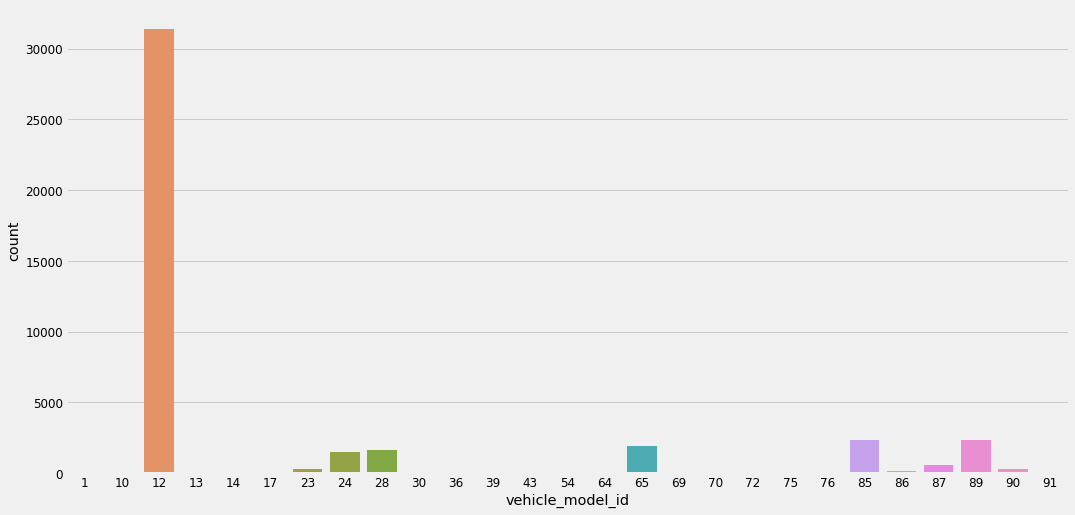

In [100]:
sns.countplot(x = 'vehicle_model_id', data = df)
plt.show()

Surge multiplier:
Suppose there are D people ordering from the same pickup cluster for the same travel_type_id(assuming that travel_type_id means the type of tansport mode viz. mini, micro, sedan, pool or outstation and vehicle_model_id is automatically assigned relative to travel_type_id) and S number of the above vehicle_model_id cars(allocated from travel_type_id) are available, then the surge multiplier can be given as:
(D - S)/D*100 percent over the base fee. This is the approach which I could come up with.

P.S. Over here, I have considered clusters of circular shape contrary to mentioned in the article for hexagonal type. Moreover, I do not have the information of the no. of cars available at that very instant of time. So, currently I am unable to produce the surge multiplier, but I am pretty sure, once I get those values, the results can be produced.